# 使用PCA对人脸图片进行处理

此部分作业要求使用PCA技术对给定的人脸数据集进行处理，你需要在该文件中完成你的代码，并输出结果。



本次使用到的人脸数据集是 ORL人脸数据集，共包含40个不同人的400张图像。此数据集下包含40个目录，每个目录下有10张图像，每个目录表示一个不同的人。所有的图像是以PGM格式存储，灰度图，图像大小宽度为92，高度为112。



数据集中部分图像示例：

![image-20230428112024592](./faces.png)



在本次作业中，你需要**按顺序**完成以下内容并且在该文件中**保留要求**的输出结果：

1. 将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100，**输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度**。

2. 得到100个特征向量后，**使用这些向量重建特征脸并输出**。示例：

   ![image2](./feature.png)

3. 使用这100个特征和对应的特征向量，自行在训练集和测试集中**分别**选择**5张**人脸图片进行人脸重建并**输出对比图**。示例：

   ![image2](./restore.png)

4. **输出**降维后**每个**新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的**信息量总和**是原始数据的多少；

5. **画出**特征个数和所携带信息数的曲线图，此处特征数**上限设置为150**，此处以150为示例：

   ![image2](./information.png)

6.  保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数*n_neighbors*为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率。**注意：此处仅进行一次PCA**,输出：不同的特征保留数和准确率的曲线图。此处以*n_neighbors=5*为示例：

   ![image2](./acc.png)

   **本次作业严禁抄袭，一经发现严肃处理**


#  附加题

若感兴趣，可以自行拍摄自己或舍友的人脸照片、或者其他较为简单且特征明显的数据集进行PCA操作。


In [111]:
# 本次作业你可能需要用到的包和函数

%matplotlib inline
# 导入所需模块
import matplotlib.pyplot as plt
import numpy as np
import os


from sklearn.neighbors import KNeighborsClassifier

# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# 读取一个文件夹下的所有图片，输入参数是文件名，返回文件地址列表
# def read_directory(directory_name):
#     faces_addr = []
#     for filename in os.listdir(directory_name):
#         faces_addr.append(directory_name + "/" + filename)
#     return faces_addr
# 测试一下输出是什么


In [112]:
# 1. 将数据集划分为80%的训练集，20%的测试集，在训练集上使用PCA将特征维度降为100，即得到100个特征和其对应的特征向量，并使用训练得到的PCA将测试集维度也压缩到100.
# 输出：压缩后的训练集维度和测试集维度、经过PCA得到的特征向量维度。
import os,re
import cv2
from sklearn.model_selection import train_test_split
# 重写了一个递归读取文件夹的函数
def read_directory(directory_name):
    faces_addr = []
    for filename in os.listdir(directory_name):
        file_path = os.path.join(directory_name, filename)  # 拼接文件路径
        if os.path.isdir(file_path):  # 如果是文件夹，递归调用
            faces_addr.extend(read_directory(file_path))
        else:  # 如果是文件，检查是否是图片
            if filename.lower().endswith(('.pgm')):  # 支持的图片格式
                faces_addr.append(file_path)
    return faces_addr

def read_images_and_labels(img_paths):
    imgs = []
    labels = []
    for path in img_paths:
        # 提取路径的倒数第二个目录作为标签
        parent_dir = os.path.basename(os.path.dirname(path))
        
        # 使用正则表达式提取数字部分
        match = re.search(r'\d+$', parent_dir)
        if match:
            label = int(match.group())  # 将标签转换为整数
        else:
            print(f"Warning: Label '{parent_dir}' does not end with a number. Skipping {path}")
            continue

        # 读取图片
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Unable to read image at {path}")
            continue
        # 将图片展平并添加到列表中
        imgs.append(img.flatten())
        labels.append(label)

    return np.array(imgs), np.array(labels)

imgs,labels = read_images_and_labels(read_directory("data/"))  # 读取图片
# 检查读取的图片数量和形状 
print("读取的图片数量:", imgs.shape[0])  # 图片数量
print("每张图片的像素数量:", imgs.shape[1])  # 每张图片的像素数量


X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.2, stratify=labels, random_state=42)
print("训练集尺寸:", X_train.shape)
print("测试集尺寸:", X_test.shape)

读取的图片数量: 400
每张图片的像素数量: 10304
训练集尺寸: (320, 10304)
测试集尺寸: (80, 10304)


PCA降维后训练集尺寸: (320, 100)
PCA降维后测试集尺寸: (80, 100)
PCA特征向量尺寸: (100, 10304)


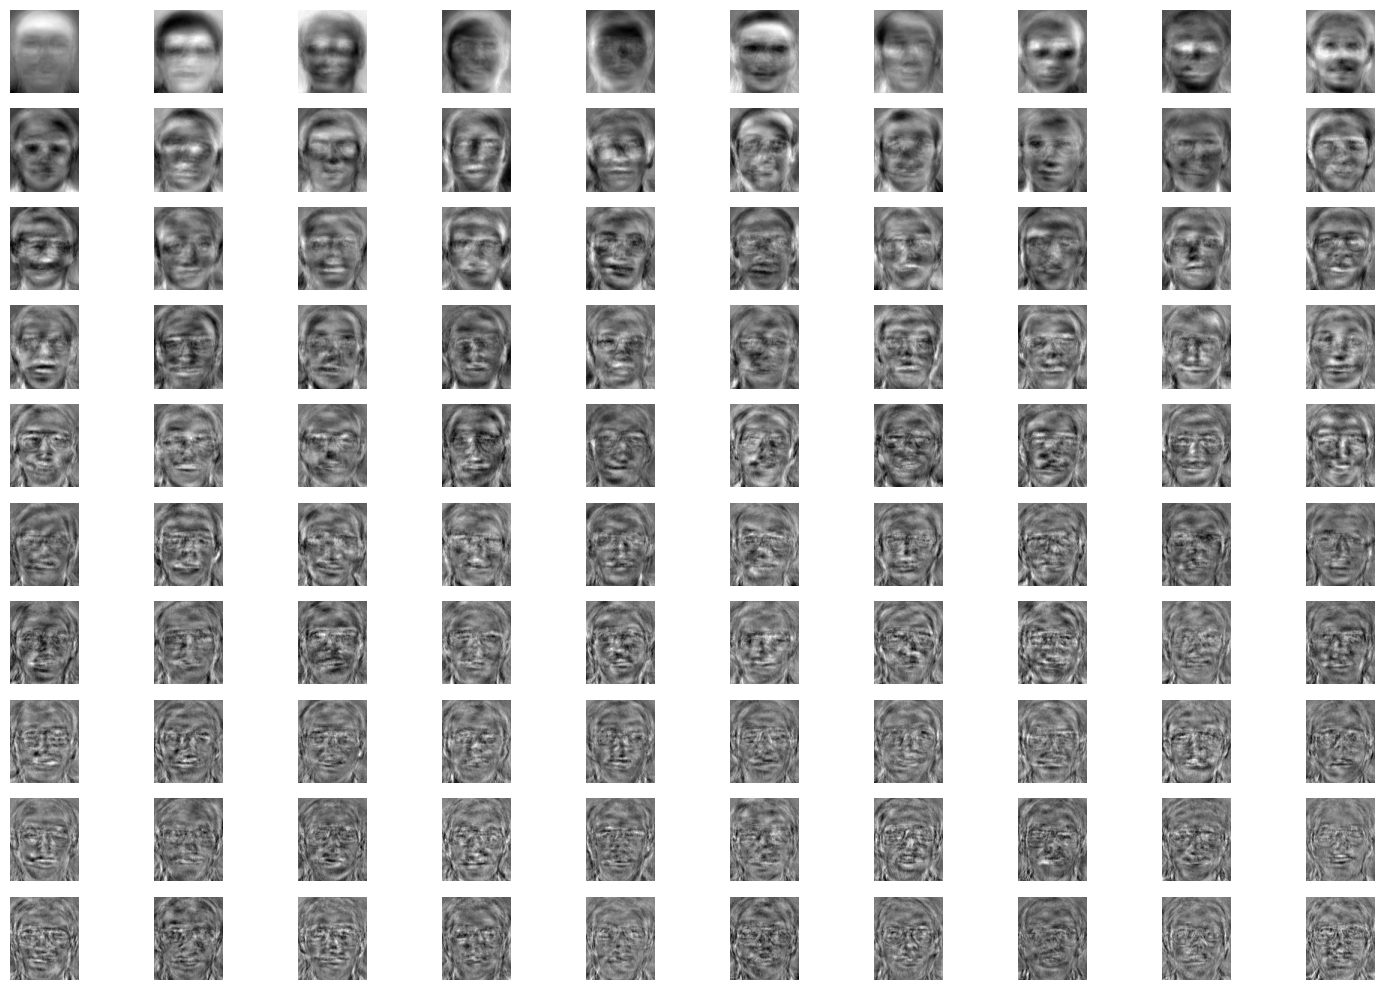

In [113]:
# 2. 得到100个特征向量后，**使用这些向量重建特征脸并输出**
from sklearn.decomposition import PCA
n_components = 100
pca_100 = PCA(n_components=n_components, whiten=True, random_state=42)
X_train_pca = pca_100.fit_transform(X_train)
X_test_pca = pca_100.transform(X_test)
print("PCA降维后训练集尺寸:", X_train_pca.shape)
print("PCA降维后测试集尺寸:", X_test_pca.shape)
print("PCA特征向量尺寸:", pca_100.components_.shape)

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 10))

# 遍历每个特征向量并显示
for i, ax in enumerate(axes.flat):
    component = pca_100.components_[i]
    img = component.reshape((112, 92))
    ax.imshow(img, cmap='gray')
    ax.axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

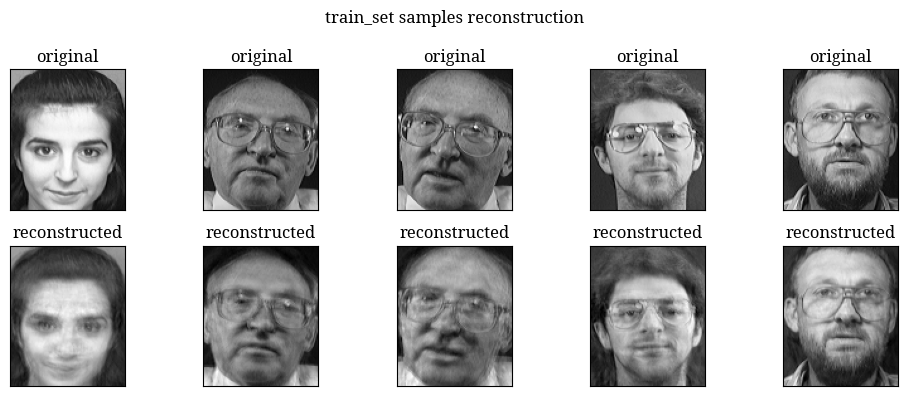

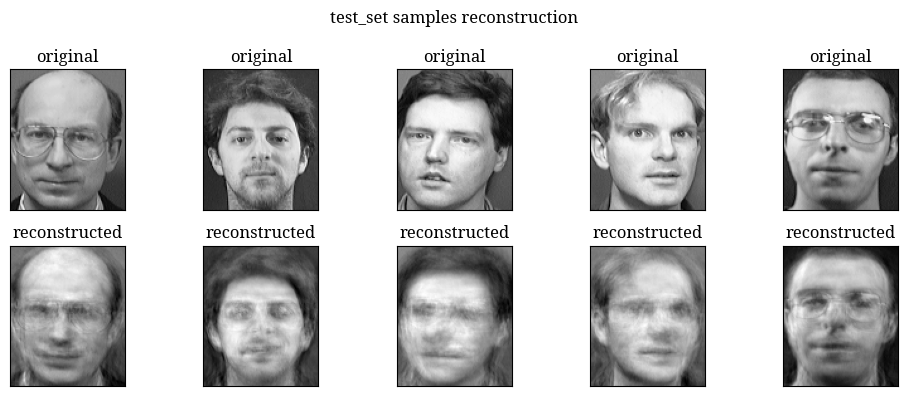

In [114]:
# 3. 使用这100个特征和对应的特征向量，自行在训练集和测试集中**分别**选择**5张**人脸图片进行人脸重建并**输出对比图**。示例：
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Noto Serif']  # Set font to Microsoft YaHei
plt.rcParams['axes.unicode_minus'] = False  # Fix minus sign display issues
img_h, img_w = 112, 92  # ORL图像尺寸

def plot_reconstruction(originals, reconstructed, title):
    """显示原图与重建图对比"""
    n = originals.shape[0]
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # 原始图片
        plt.subplot(2, n, i+1)
        plt.imshow(originals[i].reshape(img_h, img_w), cmap='gray')
        plt.title("original")  # 原图标题
        plt.xticks([])
        plt.yticks([])
        # 重构图片
        plt.subplot(2, n, i+1+n)
        plt.imshow(reconstructed[i].reshape(img_h, img_w), cmap='gray')
        plt.title("reconstructed")  # 重建图标题
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
np.random.seed(42)
idx_train = np.random.choice(X_train.shape[0], 5, replace=False)
X_train_selected = X_train[idx_train]
X_train_pca_selected = pca_100.transform(X_train_selected)
X_train_reconstructed = pca_100.inverse_transform(X_train_pca_selected)
plot_reconstruction(X_train_selected, X_train_reconstructed, "train_set samples reconstruction")  # 输出训练集样本重建对比

# 随机选择5张测试集样本
idx_test = np.random.choice(X_test.shape[0], 5, replace=False)
X_test_selected = X_test[idx_test]
X_test_pca_selected = pca_100.transform(X_test_selected)
X_test_reconstructed = pca_100.inverse_transform(X_test_pca_selected)
plot_reconstruction(X_test_selected, X_test_reconstructed, "test_set samples reconstruction")  # 输出测试集样本重建对比

In [115]:
# 4. **输出**降维后**每个**新特征向量所占的信息量占原始数据总信息量的百分比，以及所有返回特征所携带的**信息量总和**是原始数据的多少；
explained_variance_ratio = pca_100.explained_variance_ratio_
print("每个特征向量所占信息量百分比：")
print(np.round(explained_variance_ratio * 100, 2))
total_explained = explained_variance_ratio.sum()
print("100个特征总共解释原始数据的百分比：{:.2f}%".format(total_explained * 100))

每个特征向量所占信息量百分比：
[17.66 12.91  6.9   5.65  5.25  3.43  2.56  2.32  1.89  1.83  1.5   1.37
  1.15  1.08  1.01  0.92  0.89  0.85  0.74  0.73  0.71  0.64  0.63  0.56
  0.54  0.52  0.5   0.5   0.47  0.46  0.43  0.41  0.4   0.39  0.36  0.36
  0.35  0.34  0.33  0.32  0.3   0.29  0.29  0.28  0.28  0.27  0.26  0.25
  0.25  0.24  0.24  0.23  0.23  0.22  0.22  0.21  0.21  0.2   0.2   0.2
  0.19  0.19  0.18  0.18  0.18  0.17  0.17  0.16  0.16  0.16  0.16  0.15
  0.15  0.15  0.15  0.15  0.14  0.14  0.14  0.13  0.13  0.13  0.13  0.12
  0.12  0.12  0.12  0.12  0.12  0.11  0.11  0.11  0.11  0.11  0.11  0.11
  0.11  0.1   0.1   0.1 ]
100个特征总共解释原始数据的百分比：90.18%


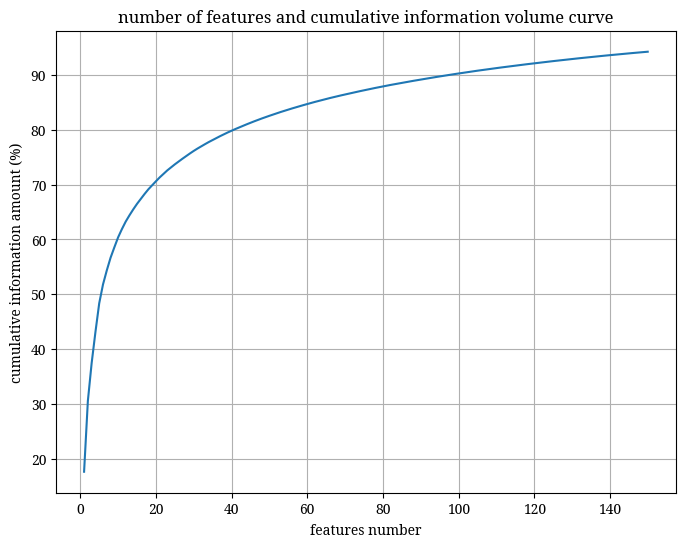

In [119]:
# 5. **画出**特征个数和所携带信息数的曲线图，此处特征数**上限设置为150**，此处以150为示例：
pca_150 = PCA(n_components=150, whiten=True, random_state=42)
pca_150.fit(X_train)
cumulative_variance = np.cumsum(pca_150.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, 151), cumulative_variance, linestyle='-')
plt.xlabel("features number")
plt.ylabel("cumulative information amount (%)")
plt.title("number of features and cumulative information volume curve")
plt.grid(True)
plt.show()

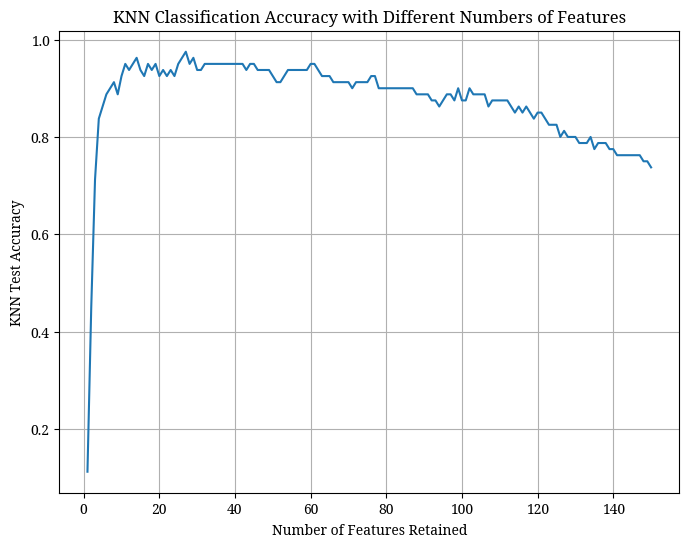

In [ ]:
# 6.  保留特征数为150，得到的训练集每次保留前（n=n+1，n初值为1）个特征，分别训练一个KNN分类器，KNN分类器的参数*n_neighbors*为3，观察并验证测试集在使用其前n个特征时KNN分类的准确率。**注意：此处仅进行一次PCA**,输出：不同的特征保留数和准确率的曲线图。此处以*n_neighbors=5*为示例：
pca_150 = PCA(n_components=150, whiten=True, random_state=42)
X_train_pca_150 = pca_150.fit_transform(X_train)
X_test_pca_150 = pca_150.transform(X_test)

accuracies = []
features_range = np.arange(1, 151)
for n in features_range:
    # 仅使用前n个特征
    X_train_subset = X_train_pca_150[:, :n]
    X_test_subset = X_test_pca_150[:, :n]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_subset, y_train)
    acc = knn.score(X_test_subset, y_test)
    accuracies.append(acc)
plt.figure(figsize=(8, 6))
plt.plot(features_range, accuracies, linestyle='-') 
plt.xlabel("Number of Features Retained")
plt.ylabel("KNN Test Accuracy")
plt.title("KNN Classification Accuracy with Different Numbers of Features")
plt.grid(True)
plt.show()